# Coche autónomo mediante Deep Learning

Autor: Andrés Martínez Martínez

##Imports

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# common use
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# image transformation
from imgaug import augmenters as iaa
from PIL import Image

# machine learning
import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split

print( f'tf.version: {tf.__version__}')
print( f'keras.version: {keras.__version__}')

tf.version: 2.8.2
keras.version: 2.8.0


##Load data

number of images: 3907
number of angles: 3907


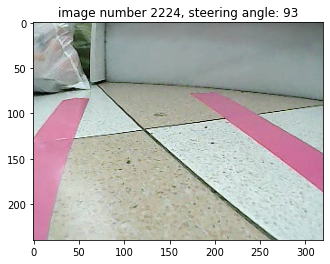

In [ ]:
# import images and get a list with its paths
data_dir = '/content/drive/My Drive/Colab Notebooks/Autonomous Car/data2/images'
file_list = os.listdir(data_dir)
image_list = [i for i in file_list if i[-4:] == '.png'] # we only want files with .png extension
image_paths = [data_dir + '/' + name for name in image_list]

# get list of angles from file names, 95 degrees is follow straight
steering_angles = [int(name[-7:-4]) for name in image_list]

print('number of images: %d' % len(image_paths))
print('number of angles: %d' % len(steering_angles))

# show an image and its angle
index = np.random.randint(0, len(image_list) - 1)
plt.imshow(Image.open(image_paths[index]))
plt.title('image number %d, steering angle: %d' % (index, steering_angles[index]))
plt.show()

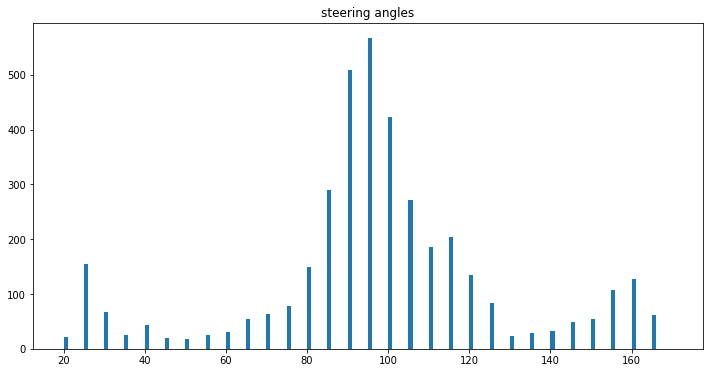

In [ ]:
# check distribution of steering angles
fig, axes = plt.subplots(figsize=(12,6))
plt.hist(steering_angles, bins=30, width=1)
plt.title('steering angles')
plt.show()

# Split and check data

Number of training examples: 3125
Number of validation examples: 782


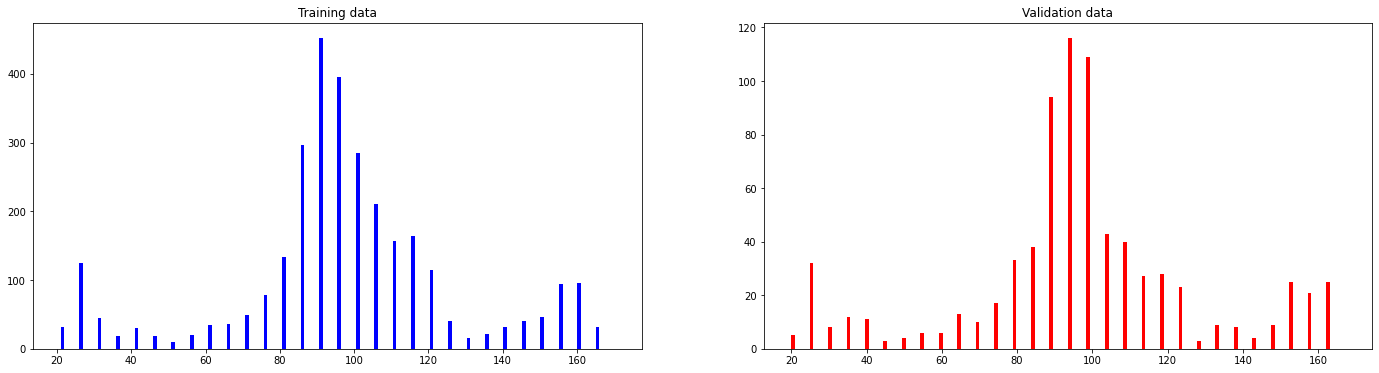

In [ ]:
# split into training and validation sets
paths_train, paths_val, Y_train, Y_val = train_test_split(image_paths, steering_angles, test_size=0.2) #random_state=123)
print("Number of training examples: %d\nNumber of validation examples: %d" % (len(paths_train), len(paths_val)))

# check distribution of both sets
fig, axes = plt.subplots(1,2, figsize=(24, 6))
axes[0].hist(Y_train, bins=30, width=1, color='blue')
axes[0].set_title('Training data')
axes[1].hist(Y_val, bins=30, width=1, color='red')
axes[1].set_title('Validation data')
plt.show()

##Augment training data

In [ ]:
def flip(image, steering_angle):
  flipped_image = cv2.flip(image,1)
  steering_angle = 190 - steering_angle

  return flipped_image, steering_angle

def blur(image):
  ksize = np.random.randint(1,5)
  blurred_image = cv2.blur(image, (ksize,ksize))

  return blurred_image

def change_brightness(image):
  brightness = iaa.Multiply((0.5, 1.2))
  image = brightness.augment_image(image)

  return image

In [ ]:
'''def augment_images(image_paths):

  n_images = len(image_paths)
  train_images = []

  for i in range(n_images):

    image = cv2.imread(image_paths[i])
    train_images.append(image)
  
    # add flipped image
    flipped_images = [cv2.flip(i,1) for i in images]
  flipped_steering_angles = [186 - i for i in steering_angles]

  images.append(flipped_images)
  labels.append(flipped_steering_angles)

  for i in range(n_images):

    np_image = np.asarray(images[i])

    #add some blurred images
    if np.random.rand() < 0.5:
      ksize = np.random.randint(1,5)
      blurred_image = cv2.blur(np_image, (ksize,ksize))

      images.append(blurred_image)
      labels.append(steering_angles[i])

    #add some images with different brightness
    brightness = iaa.Multiply((0.5, 1.2))
    bright_image = brightness.augment_image(np_image)
    
    images.append(bright_image)
    labels.append(steering_angles[i])

  return images, labels'''

'def augment_images(image_paths):\n\n  n_images = len(image_paths)\n  train_images = []\n\n  for i in range(n_images):\n\n    image = cv2.imread(image_paths[i])\n    train_images.append(image)\n  \n    # add flipped image\n    flipped_images = [cv2.flip(i,1) for i in images]\n  flipped_steering_angles = [186 - i for i in steering_angles]\n\n  images.append(flipped_images)\n  labels.append(flipped_steering_angles)\n\n  for i in range(n_images):\n\n    np_image = np.asarray(images[i])\n\n    #add some blurred images\n    if np.random.rand() < 0.5:\n      ksize = np.random.randint(1,5)\n      blurred_image = cv2.blur(np_image, (ksize,ksize))\n\n      images.append(blurred_image)\n      labels.append(steering_angles[i])\n\n    #add some images with different brightness\n    brightness = iaa.Multiply((0.5, 1.2))\n    bright_image = brightness.augment_image(np_image)\n    \n    images.append(bright_image)\n    labels.append(steering_angles[i])\n\n  return images, labels'

##Prepare data

In [ ]:
def image_preprocess(image):

  # input has to be an image because at inference we will have video frames, not paths
  
  # cut top of image
  height = len(image)
  image = image[int(height/3):,:,:]

  # resize
  image = cv2.resize(image, (200,66))

  # change to RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # normalize
  image = image / 255

  return image

In [ ]:
# create numpy arrays from preprocessed images and previously saved steering angles

X_train = np.asarray([image_preprocess(cv2.imread(i)) for i in paths_train])
X_val = np.asarray([image_preprocess(cv2.imread(i)) for i in paths_val])
Y_train = np.asarray(Y_train)
Y_val = np.asarray(Y_val)

(3125, 66, 200, 3)
(782, 66, 200, 3)
(3125,)
(782,)


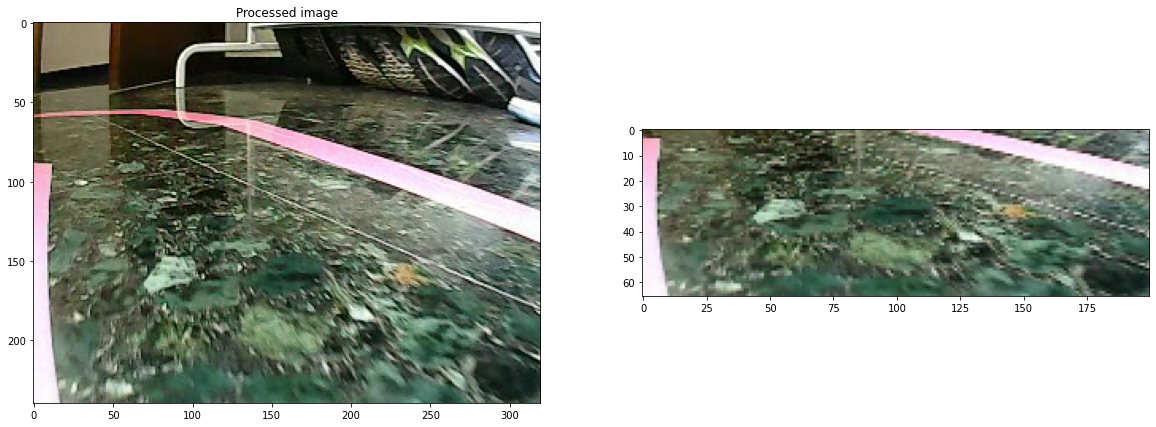

In [ ]:
# prints for debugging

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)


index = 9
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(Image.open(paths_train[index]))
axes[0].set_title('Original image')
axes[1].imshow(X_train[index])
axes[0].set_title('Processed image')
plt.show()

#Model

In [ ]:
# original size
'''#from keras.backend import relu
def model_nvidia():

  model = keras.Sequential(name='Model_Nvidia')

  # conv layers

  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(80, 160, 3), activation='elu')) # 38x78 output
  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu')) # 17x37 output
  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu')) # 7x17 output

  model.add(keras.layers.Conv2D(64, 5, activation='elu')) # 3x13 output
  model.add(keras.layers.Conv2D(64, 3, activation='elu')) # 1x11 output

  # fully connected layers
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(100, activation='elu'))
  model.add(keras.layers.Dense(50, activation='elu'))
  model.add(keras.layers.Dense(10, activation='elu'))

  # output layer
  model.add(keras.layers.Dense(1))

  # loss
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=opt)

  return model'''

"#from keras.backend import relu\ndef model_nvidia():\n\n  model = keras.Sequential(name='Model_Nvidia')\n\n  # conv layers\n\n  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(80, 160, 3), activation='elu')) # 38x78 output\n  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu')) # 17x37 output\n  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu')) # 7x17 output\n\n  model.add(keras.layers.Conv2D(64, 5, activation='elu')) # 3x13 output\n  model.add(keras.layers.Conv2D(64, 3, activation='elu')) # 1x11 output\n\n  # fully connected layers\n  model.add(keras.layers.Flatten())\n\n  model.add(keras.layers.Dense(100, activation='elu'))\n  model.add(keras.layers.Dense(50, activation='elu'))\n  model.add(keras.layers.Dense(10, activation='elu'))\n\n  # output layer\n  model.add(keras.layers.Dense(1))\n\n  # loss\n  opt = tf.keras.optimizers.Adam(learning_rate=0.001)\n  model.compile(loss='mse', optimizer=opt)\n\n  return model"

V2

In [ ]:
#from keras.backend import relu
def model_nvidia():

  model = keras.Sequential(name='Model_Nvidia')

  # conv layers
  
  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu'))
  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu'))
  model.add(keras.layers.Conv2D(64, 3, activation='elu'))
  model.add(keras.layers.Conv2D(64, 3, activation='elu'))

  # fully connected layers
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(100, activation='elu'))
  model.add(keras.layers.Dense(50, activation='elu'))
  model.add(keras.layers.Dense(10, activation='elu'))

  # output layer
  model.add(keras.layers.Dense(1))

  # loss
  opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=opt)

  return model

In [ ]:
model = model_nvidia()
print(model.summary())

Model: "Model_Nvidia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_61 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_62 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_63 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_64 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_12 (Flatten)        (None, 1152)              0         
                                                                 
 dense_48 (Dense)            (None, 100)              

##Training

In [ ]:
history = None

In [ ]:
model_output_dir = '/content/drive/My Drive/Colab Notebooks/Autonomous Car/model'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'autonomous_car_check.h5'), verbose=1, save_best_only=True)

history = model.fit(X_train, Y_train, batch_size=32,
                              epochs=40,
                              validation_data = (X_val, Y_val),
                              validation_steps=8,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir,'autonomous_car_final.h5'))

Epoch 1/40
98/98 [==============================] - ETA: 0s - loss: 1405.4611
Epoch 1: val_loss improved from inf to 997.60632, saving model to /content/drive/My Drive/Colab Notebooks/Autonomous Car/model/autonomous_car_check.h5
98/98 [==============================] - 27s 263ms/step - loss: 1405.4611 - val_loss: 997.6063
Epoch 2/40
98/98 [==============================] - ETA: 0s - loss: 916.9083
Epoch 2: val_loss improved from 997.60632 to 915.07660, saving model to /content/drive/My Drive/Colab Notebooks/Autonomous Car/model/autonomous_car_check.h5
98/98 [==============================] - 23s 237ms/step - loss: 916.9083 - val_loss: 915.0766
Epoch 3/40
98/98 [==============================] - ETA: 0s - loss: 898.0477
Epoch 3: val_loss improved from 915.07660 to 861.57129, saving model to /content/drive/My Drive/Colab Notebooks/Autonomous Car/model/autonomous_car_check.h5
98/98 [==============================] - 23s 237ms/step - loss: 898.0477 - val_loss: 861.5713
Epoch 4/40
98/98 [==

# Review learning curves

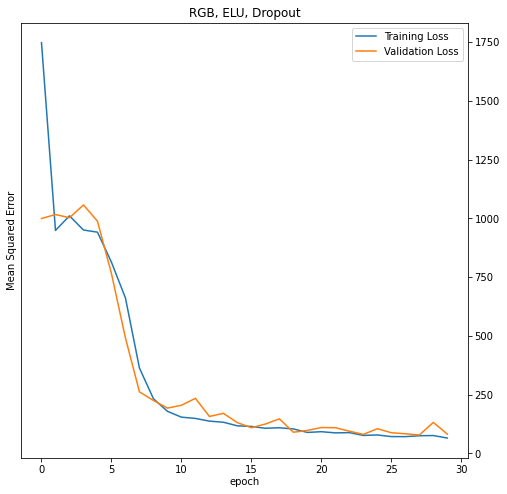

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.title('RGB, ELU, Dropout')
plt.xlabel('epoch',labelpad=2)
ax.yaxis.tick_right()
plt.show()

# Conversión a TF Lite

In [ ]:
os.chdir(model_output_dir)
best_model = tf.keras.models.load_model('best model/autonomous_car_final.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

with open('autonomous_car_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpz9l71yd_/assets


INFO:tensorflow:Assets written to: /tmp/tmpz9l71yd_/assets
